# Aprendizado de Máquinas: Trabalho Final

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# plot configs
sns.set(rc={'figure.figsize':(10,10)});
plt.figure(figsize = (15,15));

<Figure size 1080x1080 with 0 Axes>

## 1. O Dataset

Para a realização deste trabalho foi utilizado o clássico dataset do [titanic](https://www.kaggle.com/competitions/titanic).

### 1.1 Importando os Dados

In [2]:
# import the train data
train = pd.read_csv('data/train.csv')

# the test data is split into two parts
# import the test data
test = pd.read_csv('data/test.csv')
# import the dataset with the classes
gender = pd.read_csv('data/gender_submission.csv')
# merge the test data with it's classes
test = pd.merge(test, gender, on='PassengerId')

# merge the train and test data to make the analysis
merged_df = train.append(test, ignore_index=True).set_index('PassengerId')
merged_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


### 1.2. Preparação dos Dados para a Análise Exploratória

Inicialmente, foi removida coluna `Name` já que como é uma label, quase que análoga ao `PassengerId`, não será de muito uso para o modelo. Com um tratamento avançado seria possível tentar relacionar o sobrenome à família da pessoa. Porém há o caso de pessoas com o mesmo sobrenome advindas de famílias diferentes que não seria possível tratar.

In [4]:
merged_df = merged_df.drop('Name', axis=1)

Outra questão importante é a idade, que possui $263$ valores faltantes. Inicialmente para lidar com estes casos irei simplesmente substituir tais valores pela média de idade dos passageiros.

Mean Age of the Passengers: 29.881137667304014


<AxesSubplot:ylabel='Frequency'>

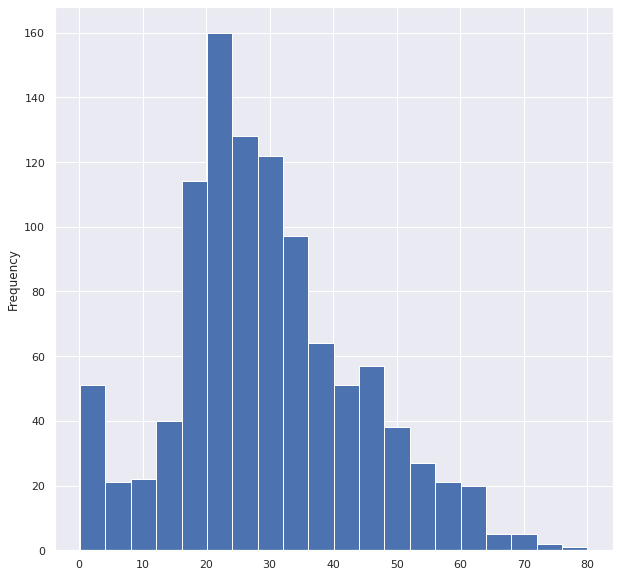

In [5]:
print(f'Mean Age of the Passengers: {merged_df["Age"].mean()}')
merged_df['Age'].plot(kind = 'hist', bins = 20)

In [6]:
merged_df['Age'] = merged_df['Age'].fillna(round(merged_df['Age'].mean(), 0))

A coluna `Embarked` possui 2 valores faltantes, portanto irei utilzar a moda da mesma para tratar destes valores. Como a moda é um valor extremamente mais frequente do que os demais, tal substituição não terá um impacto significativo na performance do modelo já que, provavelmente, os dois passageiros realmente embarcaram no porto de Southampton.

Moda da coluna de Embarque: S


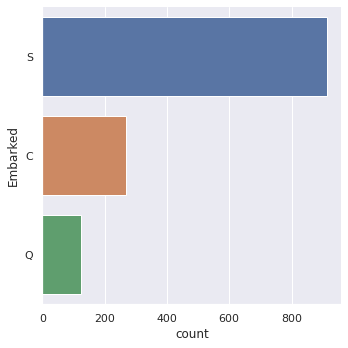

In [7]:
# calculate the mode
embarked_mode = merged_df['Embarked'].mode()
print(f'Moda da coluna de Embarque: {embarked_mode[0]}')

# plot a barplot with the counts of each class
sns.catplot(data = merged_df, y = 'Embarked', kind = 'count')

# replace the missing values with the mode
merged_df['Embarked'] = merged_df['Embarked'].fillna(embarked_mode[0])

A última coluna a ser tratada é a coluna `Fare`. Tal coluna é extremamente influenciada pela *feature* `Pclass`, ou seja, à classe do passageiro, como pode ser visto no *boxplot* abaixo.

Mean Fare of Pclass 1: 87.51
Median Fare of Pclass 1: 60.0

Mean Fare of Pclass 2: 21.18
Median Fare of Pclass 2: 15.05

Mean Fare of Pclass 3: 13.3
Median Fare of Pclass 3: 8.05



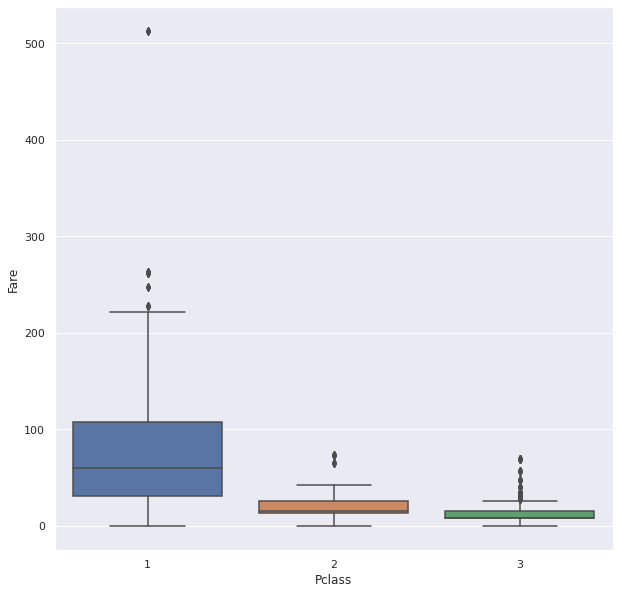

In [8]:
sns.boxplot(data = merged_df, x = 'Pclass', y = 'Fare')

for i in range(3):
    mean = round(merged_df[merged_df['Pclass'] == (i+1)]['Fare'].mean(), 2)
    median = round(merged_df[merged_df['Pclass'] == (i+1)]['Fare'].median(), 2)
    print(f'Mean Fare of Pclass {i+1}: {mean}\nMedian Fare of Pclass {i+1}: {median}\n')

Outra observação importante, é que a média desta classe está sendo muito influenciada por valores extremos, por conta de diferir bastante da mediana, logo utilizarei este segundo valor para preencher o valore faltante.

Como o valor faltante é de classe 3

In [9]:
# replace the missing values with the median of the Pclass 3
merged_df['Fare'] = merged_df['Fare'].fillna(round(merged_df[merged_df['Pclass'] == 3]['Fare'].median(), 2))

Outro problema é o *outlier* com um valor para `Fare` muito extremo, que irei tratar substituindo pela mediana da primeira classe:

In [10]:
merged_df[merged_df['Fare'] > 300]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
259,1,1,female,35.0,0,0,PC 17755,512.3292,NaN,C
680,1,1,male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,1,male,35.0,0,0,PC 17755,512.3292,B101,C
1235,1,1,female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C


In [11]:
# change the extreme values to the median of the Pclass 1
merged_df.loc[merged_df.Fare > 300, 'Fare'] = round(merged_df[merged_df['Pclass'] == 1]['Fare'].median(), 2)

Por fim, a coluna cabine possui muitos valores nulos e não é uma coluna que descreve muito bem os dados, logo optei por simplesmente remover ela do dataset. Também a coluna `Ticket` possui mais de 900 valores distintos, então tratar deles tal qual eles estão seria inviável.

In [12]:
# count the Ticket unique values
len(merged_df['Ticket'].unique())

929

In [13]:
merged_df = merged_df.drop('Cabin', axis=1)
merged_df = merged_df.drop('Ticket', axis=1)
merged_df.info()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1309 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 124.3+ KB


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### 1.3. Tratando os dados categóricos

Primeiro transformei a coluna `Embarked` em *dummies*, ou seja, em 3 colunas binárias, uma para cada um dos pontos de embarque, onde $Embarked_i = 1$, sendo $i=\{C, Q, S\}$, significa que o passageiro embarcou no porto em questão e $Embarked_i=0$ caso contrário.

In [14]:
df_dummies = pd.get_dummies(merged_df, columns=['Embarked'])

Então transformei a coluna `Sex` da mesma forma, porém apenas deixando ela como binário, sendo `male = 1` e `female = 0`:

In [25]:
df_dummies = pd.get_dummies(merged_df, columns=['Sex'], drop_first = True)

Então o dataset final fica:

In [30]:
df_dummies.info()
df_dummies.head()

NameError: name 'df_dummies' is not defined

### 1.4. Análise Exploratória

Agora examinando algumas métricas das colunas numéricas:

In [16]:
merged_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.377387,2.294882,29.905019,0.498854,0.385027,31.893980,0.206264,0.093965,0.699771
std,0.484918,0.837836,12.883281,1.041658,0.865560,44.450655,0.404777,0.291891,0.458533
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000,0.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,9.000000,263.000000,1.000000,1.000000,1.000000


In [29]:
numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

#### Survived
Usando o método `pd.Series.value_counts()` conseguimos ver que o dataset de treino contém dados referentes à $494$ sobreviventes e $815$ pessoas que não sobreviveram.

0    815
1    494
Name: Survived, dtype: int64

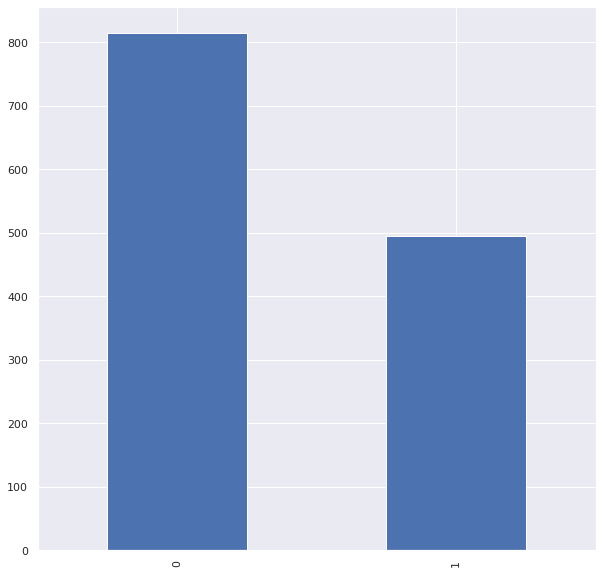

In [17]:
merged_df['Survived'].value_counts().plot(kind='bar')
merged_df['Survived'].value_counts()

#### Boxplot de `Fare` por classe (`PClass`)

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

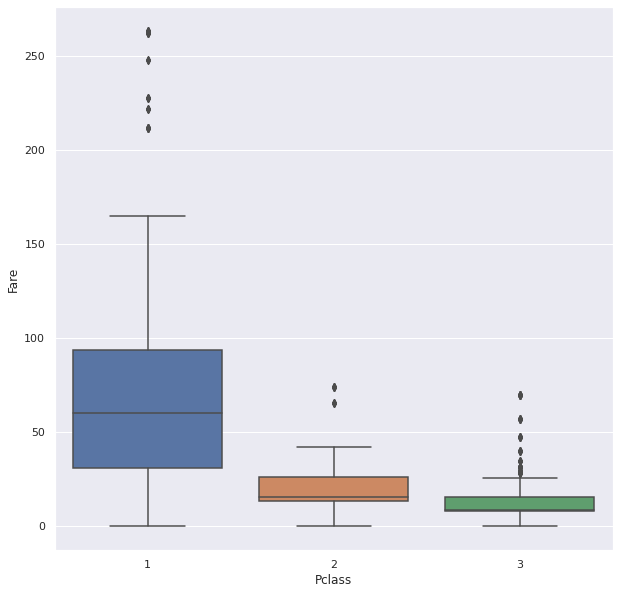

In [18]:
sns.boxplot(data = merged_df, x = 'Pclass', y = 'Fare')

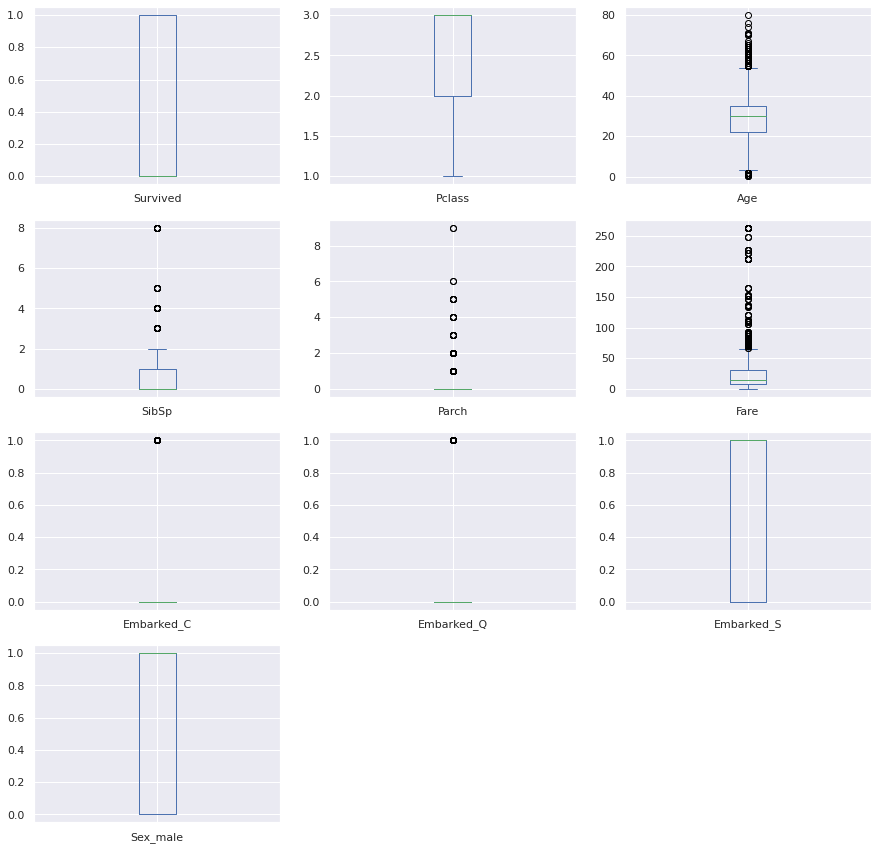

In [28]:
merged_df.plot(kind='box', subplots=True, layout=(4, 3), sharex=False, sharey=False, figsize=(15, 15));

In [20]:
rs = np.random.RandomState(0)

# df = pd.DataFrame(rs.rand(20, 20))
corr = merged_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.264710,-0.048806,0.002370,0.108919,0.232247,0.121156,0.040950,-0.133020
Pclass,-0.264710,1.000000,-0.365598,0.060832,0.018322,-0.602317,-0.269658,0.230491,0.091320
Age,-0.048806,-0.365598,1.000000,-0.190774,-0.131174,0.171250,0.076244,-0.011551,-0.059953
SibSp,0.002370,0.060832,-0.190774,1.000000,0.373587,0.201606,-0.048396,-0.048678,0.073709
Parch,0.108919,0.018322,-0.131174,0.373587,1.000000,0.253903,-0.008635,-0.100943,0.071881
Fare,0.232247,-0.602317,0.171250,0.201606,0.253903,1.000000,0.272372,-0.141220,-0.150543
Embarked_C,0.121156,-0.269658,0.076244,-0.048396,-0.008635,0.272372,1.000000,-0.164166,-0.778262
Embarked_Q,0.040950,0.230491,-0.011551,-0.048678,-0.100943,-0.141220,-0.164166,1.000000,-0.491656
Embarked_S,-0.133020,0.091320,-0.059953,0.073709,0.071881,-0.150543,-0.778262,-0.491656,1.000000


In [21]:
merged_df.corr().drop('Survived')['Survived']

Pclass       -0.264710
Age          -0.048806
SibSp         0.002370
Parch         0.108919
Fare          0.232247
Embarked_C    0.121156
Embarked_Q    0.040950
Embarked_S   -0.133020
Name: Survived, dtype: float64

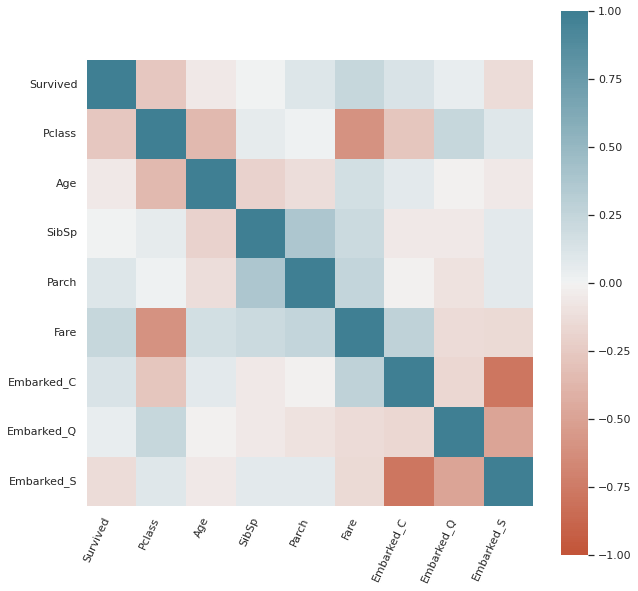

In [22]:
ax = sns.heatmap(   corr, 
                    vmin=-1, vmax=1, center=0, 
                    cmap=sns.diverging_palette(20, 220, n=200), 
                    square=True
                )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=65,
    horizontalalignment='right'
);

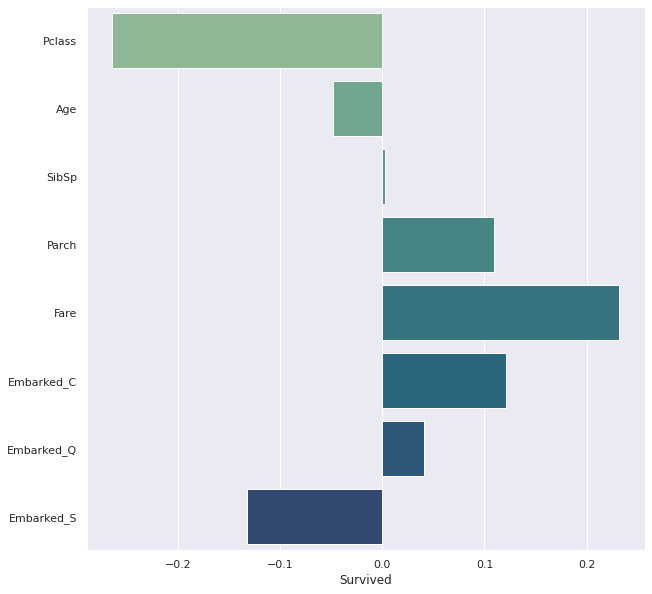

In [23]:
aux_corr = corr['Survived'].drop('Survived');
sns.barplot(
    x = aux_corr, 
    y = aux_corr.index, 
    palette='crest');

/home/gianlucca/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/gianlucca/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

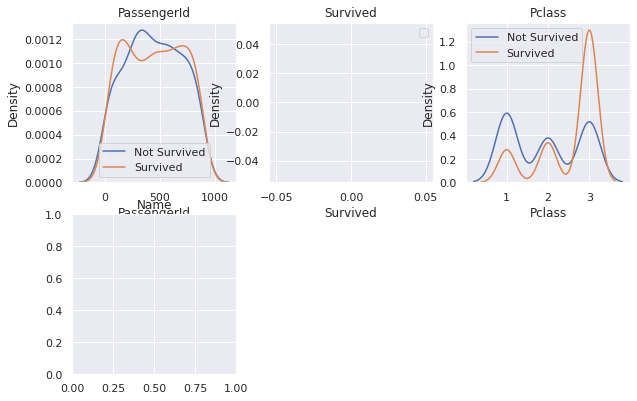

In [24]:
survived = train[train['Survived'] == 1]
not_survived = train[train['Survived'] == 0]

for ax,col in enumerate(train.columns[:9]):
    plt.subplot(3,3, ax + 1)
    plt.title(col)
    sns.kdeplot(x = survived[col], label="Not Survived")
    sns.kdeplot(x = not_survived[col], label="Survived")
    plt.legend()
plt.tight_layout()